# Demo Long short-term memory (LSTM) para estimar un valor en una serie en el tiempo
Basado en https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/ 

1) Cargar librerías:

In [1]:
#@title Librerías a usar
import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import ConvLSTM2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import math

print("Librerías cargadas")

Librerías cargadas


2) Cargar los datos:

In [2]:
# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/datos/'  #@param {type:"string"}


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
## selección de los parámetros 

#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'CLIMA.csv'  #@param {type:"string"}
#@markdown ### Nombre del atributo a estimar:
atributo_estimar = 'CantLluvia' #@param {type:"string"}
#@markdown ### Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   80#@param {type:"integer"}

## aplicación de los parámetros elegidos

# define nombre atributo de CLASE para ejemplo IRIS
ClassAttributeName = atributo_estimar

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

print("Configuración definida de ", archivo_datos)


Configuración definida de  CLIMA.csv


In [4]:
#@title Cargar datos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos)
print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())

# genera los datos solo con la clase para entrenar y probar
Yori = np.array(df.pop(ClassAttributeName))
Xori = np.array(df)



> Cabecera: 
   MaxTemp  MinTemp  CantLluvia  VelViento    Humedad   RadSolar
0     28.0   16.851         0.0   4.115179  54.014606  34.023094
1     29.0   15.581         0.0   3.828738  54.534280  33.991928
2     33.0   19.627         0.0   4.481996  50.441004  29.988900
3     35.0   19.131         0.0   4.038467  47.209254  30.184419
4     29.0    8.614         0.0   2.751128  34.174579  27.685916

> Características: 
            MaxTemp       MinTemp    CantLluvia     VelViento       Humedad  \
count  25974.000000  25974.000000  25974.000000  25974.000000  25974.000000   
mean      23.306640     12.267206      2.681185      3.953890     64.749881   
std        7.795314      5.563365      9.276417      1.298974     17.197800   
min        6.000000     -3.734000      0.000000      0.879855     13.768390   
25%       17.000000      8.087250      0.000000      3.021895     52.244933   
50%       23.000000     12.292000      0.000000      3.816113     65.828114   
75%       29.000000   

In [5]:
#@title Normalizar datos de entrada (opcional)

aplica_normalizacion = True #@param {type:"boolean"}
#@markdown Si se aplica, seleccione el tipo de método de normalización a aplicar:
tipo_normalizacion = "Standard Scaler" #@param ["Standard Scaler", "MinMax Scaler", "MaxAbs Scaler", "Robust Scaler"]

if aplica_normalizacion:

  print("10 primeros datos de Entrada antes de normalizar: ")
  print(Xori[:10])

  from sklearn import preprocessing

  # elegir el método de normalización
  if tipo_normalizacion == "Standard Scaler": 
    scaler = preprocessing.StandardScaler()
  elif tipo_normalizacion == "MinMax Scaler": 
    scaler = preprocessing.MinMaxScaler()
  elif tipo_normalizacion == "MaxMax Scaler": 
    scaler = preprocessing.MaxAbsScaler()
  elif tipo_normalizacion == "Robust Scaler": 
    scaler = preprocessing.RobustScaler()
  
  # normaliza los datos de entrada
  Xori = scaler.fit_transform(Xori)
  
  print("\n\n10 primeros datos de Entrada después de normalizar: ")
  print(Xori[:10])

10 primeros datos de Entrada antes de normalizar: 
[[28.         16.851       4.11517889 54.01460647 34.02309402]
 [29.         15.581       3.82873837 54.53428037 33.9919281 ]
 [33.         19.627       4.48199627 50.44100419 29.98889964]
 [35.         19.131       4.03846654 47.20925441 30.18441906]
 [29.          8.614       2.75112845 34.17457853 27.6859161 ]
 [30.          7.584       2.36142894 31.15338649 27.75296214]
 [24.         16.603       2.97655439 84.33995446 10.66077828]
 [25.         15.895       2.5238168  83.61034127 11.21641362]
 [17.          7.029       4.80350817 73.08001316 14.97065976]
 [17.          6.465       4.06358332 74.15440566 15.50559312]]


10 primeros datos de Entrada después de normalizar: 
[[ 0.60208618  0.82394055  0.1241687  -0.62423575  1.7047345 ]
 [ 0.73037085  0.59565707 -0.0963484  -0.5940177   1.70152134]
 [ 1.24350954  1.3229287   0.40656418 -0.8320339   1.28881509]
 [ 1.50007888  1.23377232  0.06511147 -1.01995398  1.30897285]
 [ 0.730370

In [6]:
#@title Generar serie como secuencia de datos

cantidad_intervalos_secuencia = 3 #@param {type:"integer"}

usar_atributos_secuencia = "Todos" #@param ["Solo atributo a Estimar", "Solo atributos de Entrada", "Todos"]

if cantidad_intervalos_secuencia < 1:
  cantidad_intervalos_secuencia = 1

# funciones auxilliares
def split_sequence(datosX, datosY, n_steps, atr_seq):
  x, y = [], []
  if len(datosX) != len(datosY):
    print("No coincide el largo de los datos X e Y!!!")
    return None, None
  for i in range(len(datosY)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(datosY)-1:
      break
    # gather input and output parts of the pattern
    if atr_seq == "Y":
      # sólo atributo a estimar (anteriores)
      seq_x = datosY[i:end_ix]
      seq_y = datosY[end_ix]   
    elif atr_seq == "X":
      # sólo atributos de entrada (anteriores y actuales)
      seq_x = datosX[i:end_ix]
      seq_y = datosY[end_ix-1]   
    else:
      # atributos de entrada y a estimar (anteriores)
      seq_xa = datosX[i:end_ix]
      seq_xb = datosY[i:end_ix] 
      seq_y = datosY[end_ix]  
      seq_x = []
      for xa, xb in zip(seq_xa, seq_xb):        
        xa = list(xa)
        xa.append(xb)
        seq_x.append(xa)

    x.append( seq_x )
    y.append( seq_y )
  return np.array(x), np.array(y)

# muestra los primeros "cant" datos
def mostrarEjemplos(X, Y, cant=5):
  for i in range(min(len(X), cant)):
    print(X[i], Y[i])
  print("\n")

print("\n> Antes de generar serie: ")
mostrarEjemplos(Xori, Yori)

# genera secuencias
print("> Generando series con ", cantidad_intervalos_secuencia ," intervalos ")
if (Xori.shape[1] == 0) or usar_atributos_secuencia == "Solo atributo a Estimar": 
  atrSeq = "Y"
  cant_atributos_entrada = 1
elif usar_atributos_secuencia == "Solo atributos de Entrada":
  atrSeq = "X"
  cant_atributos_entrada = Xori.shape[1]
else: # "Todos"
  atrSeq = "XY"
  cant_atributos_entrada = Xori.shape[1] + 1
X, Y = split_sequence(Xori, Yori, cantidad_intervalos_secuencia, atrSeq)

print("\n> Después de generar serie: ")
mostrarEjemplos(X, Y)



> Antes de generar serie: 
[ 0.60208618  0.82394055  0.1241687  -0.62423575  1.7047345 ] 0.0
[ 0.73037085  0.59565707 -0.0963484  -0.5940177   1.70152134] 0.0
[ 1.24350954  1.3229287   0.40656418 -0.8320339   1.28881509] 0.0
[ 1.50007888  1.23377232  0.06511147 -1.01995398  1.30897285] 0.0
[ 0.73037085 -0.65666657 -0.92594968 -1.77789551  1.05138094] 0.0


> Generando series con  3  intervalos 

> Después de generar serie: 
[[ 0.60208618  0.82394055  0.1241687  -0.62423575  1.7047345   0.        ]
 [ 0.73037085  0.59565707 -0.0963484  -0.5940177   1.70152134  0.        ]
 [ 1.24350954  1.3229287   0.40656418 -0.8320339   1.28881509  0.        ]] 0.0
[[ 0.73037085  0.59565707 -0.0963484  -0.5940177   1.70152134  0.        ]
 [ 1.24350954  1.3229287   0.40656418 -0.8320339   1.28881509  0.        ]
 [ 1.50007888  1.23377232  0.06511147 -1.01995398  1.30897285  0.        ]] 0.0
[[ 1.24350954  1.3229287   0.40656418 -0.8320339   1.28881509  0.        ]
 [ 1.50007888  1.23377232  0.0651114

In [7]:
#@title Preparar datos 

# reshape de [cant ejemplos, datos entrada] into [cant ejemplos, intervalos, datos entrada]
X =  X.reshape((X.shape[0], cantidad_intervalos_secuencia, cant_atributos_entrada))

# separa al azar usando muestreo estratificado con proporción indicada
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain))

print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, intervalos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, intervalos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))



> Para Entrenamiento: 
 - x_train (cant ejemplos, intervalos, datos entrada):  (20776, 3, 6)
 - y_train (cant):  20776

 Para Prueba: 
 - x_test (cant ejemplos, intervalos, datos entrada):  (5195, 3, 6)
 - y_test (cant):  5195


3) Establecer el modelo para la RNA

Modelo creado con  2  capas:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 500)               387000    
_________________________________________________________________
output (Dense)               (None, 1)                 501       
Total params: 387,501
Trainable params: 387,501
Non-trainable params: 0
_________________________________________________________________




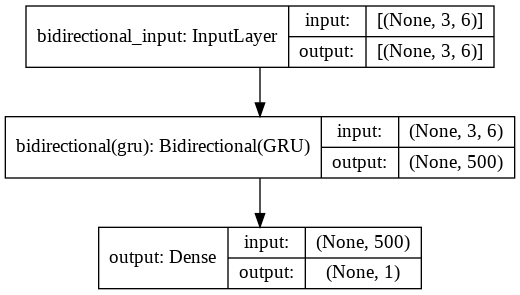

In [8]:
#@title Establecer modelo

tipo_red = "Bidirectional" #@param ["Simple", "Stacked", "Bidirectional", "ConvLSTM2D" ]
tipo_capa = "GRU" #@param ["LSTM", "GRU"]
cant_rnn_neuronas = 250 #@param {type: "integer"}
opt_tipo = "Adam" #@param ["Gradiente Decreciente", "Adam", "Adadelta", "Adagrad", "Adamax", "Nadam", "FTRL"]
opt_learning_rate = 0.001 #@param {type: "number"}

if cant_rnn_neuronas < 5:
  cant_rnn_neuronas = 5

# define la arquitectura de capas teniendo en cuenta la definición dada anteriomente
model = Sequential()
if tipo_red == "Simple":

  # una capa
  if tipo_capa == "LSTM":
    model.add( LSTM(cant_rnn_neuronas, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])) )
  else:
    model.add( GRU(cant_rnn_neuronas, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])) )

elif tipo_red == "Stacked":
  # dos capas 
  if tipo_capa == "LSTM":
    model.add( LSTM(cant_rnn_neuronas, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])) )
    model.add( LSTM(cant_rnn_neuronas, activation='relu') )
  else:
    model.add( GRU(cant_rnn_neuronas, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])) )
    model.add( GRU(cant_rnn_neuronas, activation='relu') )

elif tipo_red == "Bidirectional":
  # una capa bidireccional
  if tipo_capa == "LSTM":
    model.add( Bidirectional(LSTM(cant_rnn_neuronas, activation='relu'), input_shape=(x_train.shape[1], x_train.shape[2])) )
  else:
    model.add( Bidirectional(GRU(cant_rnn_neuronas, activation='relu'), input_shape=(x_train.shape[1], x_train.shape[2])) ) 

elif tipo_red == "ConvLSTM2D":
  # una capa mezcla CNN y LSTM ya integrada
  # (para usarla hay que ajustar los datos antes)
  auxCols = 2  
  while True:    
    if (x_train.shape[1]%auxCols) == 0:
      break
    auxCols = auxCols + 1
    if auxCols >= 100:
      auxCols = 1
      break
  x_train = x_train.reshape((x_train.shape[0], x_train.shape[1]//auxCols, 1, auxCols, x_train.shape[2]))
  x_test = x_test.reshape((x_test.shape[0], x_test.shape[1]//auxCols, 1, auxCols, x_test.shape[2]))
  print("-- para ConvLSTM2D se ajustan los datos de entrada a: ", x_train.shape, "y", x_test.shape, "--\n")
  # (define las capas)
  model.add( ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(x_train.shape[1], 1, 2, x_train.shape[2])) )
  model.add( Flatten() )

# se genera una capa lineal con una salida numérica
model.add( Dense(1, activation=None, name='output') )

if opt_tipo == "Gradiente Decreciente":
  opt = keras.optimizers.SGD(learning_rate=opt_learning_rate)
elif opt_tipo == "Adam":
  opt = keras.optimizers.Adam(learning_rate=opt_learning_rate)
elif opt_tipo == "Adadelta":
  opt = keras.optimizers.Adadelta(learning_rate=opt_learning_rate)
elif opt_tipo == "Adagrad":
  opt = keras.optimizers.Adagrad(learning_rate=opt_learning_rate)
elif opt_tipo == "Adamax":
  opt = keras.optimizers.Adamax(learning_rate=opt_learning_rate)
elif opt_tipo == "Nadam":
  opt = keras.optimizers.Nadam(learning_rate=opt_learning_rate)
elif opt_tipo == "FTRL":
  opt = keras.optimizers.Ftrl(learning_rate=opt_learning_rate)
else:
  opt = keras.optimizers.Adam()

# utiliza un loss de valor numérico
model.compile(optimizer=opt, loss='mse')

print("Modelo creado con ", len(model.layers), " capas:")
model.summary()
print("\n")
plot_model(model, show_layer_names=True, show_shapes=True)


4) Entrenar el modelo de la RNA:

In [9]:
#@title Entrenar

cant_epocas_entrenamiento =   150#@param {type:"integer"}

# cantidad de épocas del entrenamiento
cantEpocas = (1 if cant_epocas_entrenamiento<1 else cant_epocas_entrenamiento)

activar_corte_por_estabilidad_error_val = False 

# separa al azar usando muestreo al azar del 10%
# para tomar algunos como datos de validación
x_t, x_v, y_t, y_v = train_test_split(x_train, 
                                       y_train, 
                                       test_size=0.1)


print("\n> De los ", len(x_train), "ejemplos de entrenamiento: ")
print("            se usan ", len(x_t), "ejemplos para entrenar ")
print("            y ", len(x_v), "ejemplos para validar.")

print("\n\n>Comienza el Entrenamiento:")

if activar_corte_por_estabilidad_error_val:
  # se agrega un callBack para que corte 
  # si el error de validación no sigue bajando
  # y devuelva los mejores pesos obtenidos
  early_stopping_monitor = keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=0.01,
      patience=20,
      verbose=0,
      mode='min',
      baseline=None,
      restore_best_weights=True
  )
  callbacksEntr = [early_stopping_monitor]
else:
  early_stopping_monitor = None
  callbacksEntr = []

# lleva a cabo el entrenamiento
history = model.fit(x_t, y_t,
          epochs = cantEpocas, 
          validation_data=(x_v, y_v,),
          callbacks=callbacksEntr ) 

print("\n>Entrenamiento Finalizado.")



> De los  20776 ejemplos de entrenamiento: 
            se usan  18698 ejemplos para entrenar 
            y  2078 ejemplos para validar.


>Comienza el Entrenamiento:
Epoch 1/150
585/585 [==============================] - 16s 22ms/step - loss: 51.0178 - val_loss: 51.1794
Epoch 2/150
585/585 [==============================] - 12s 21ms/step - loss: 47.7856 - val_loss: 50.0632
Epoch 3/150
585/585 [==============================] - 12s 21ms/step - loss: 47.2552 - val_loss: 51.2822
Epoch 4/150
585/585 [==============================] - 12s 21ms/step - loss: 46.8907 - val_loss: 49.8425
Epoch 5/150
585/585 [==============================] - 12s 21ms/step - loss: 46.4162 - val_loss: 50.9383
Epoch 6/150
585/585 [==============================] - 12s 21ms/step - loss: 46.1554 - val_loss: 49.9485
Epoch 7/150
585/585 [==============================] - 12s 21ms/step - loss: 45.9914 - val_loss: 51.2442
Epoch 8/150
585/585 [==============================] - 12s 21ms/step - loss: 45.7951 - val_loss:

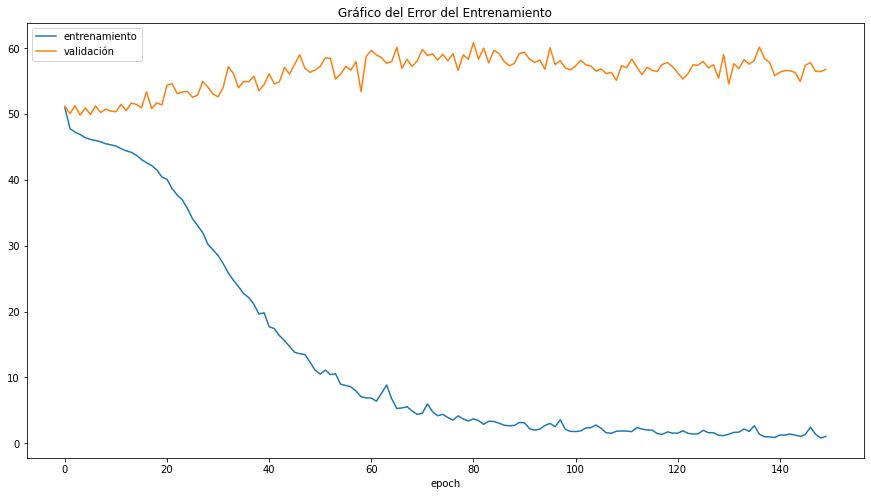

In [10]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8)) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()


*** Resultados con datos de Entrenamiento: 


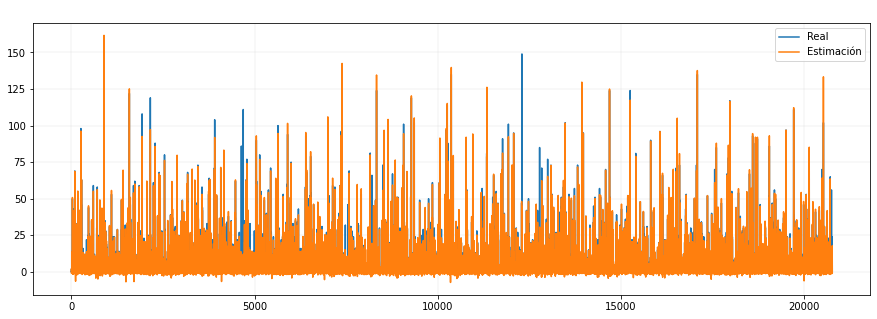




 Error Absoluto: 
            Mínimo: 0.00005 
            Promedio: 0.83833 ± 2.40444
            Máximo: 133.41337 


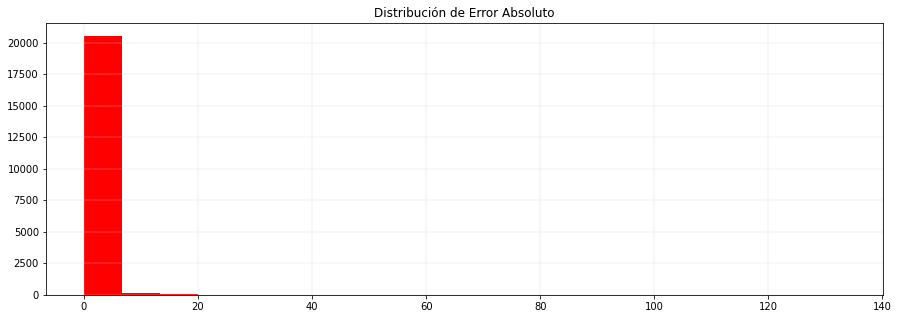


 Error Relativo: 
            Mínimo: 0.01% 
            Promedio: 4780795.24 ± 9514298.65
            Máximo: 243435974.12% 


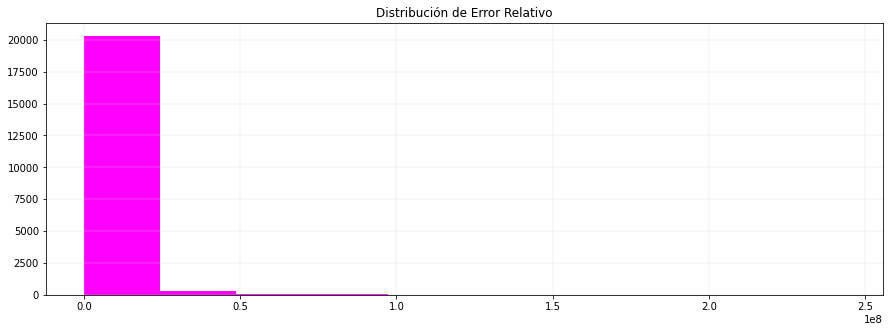

In [11]:
#@title Probar red entrenada con datos de entrenamiento

mostrar_detalle_entrenamiento = False #@param {type:"boolean"}

# función auxiliar para el cálculo de error
def calcErrores(pred, real, mostrarDetalle=False):
  arAbs = []
  arRel = []
  
  if mostrarDetalle:
    print("\n")
    print("\t Real \t\t\t Estimado \t\t Error Absoluto \t Error Relativo")
  
  for pV, r in zip(pred, real):
    # toma el valor estimado/predecido
    p = pV[0]
    # controla que sean números
    if not(math.isnan(r) or math.isnan(p)):
      # hace los cálculos
      eAbs = abs(r - p)
      if r != 0:
        eRel = (eAbs / r)*100.0
      else:
        eRel = (eAbs / 0.00001)*100.0
      arAbs.append(eAbs)
      arRel.append(eRel)
    
      if mostrarDetalle:
        print("\t{:>8.2f} \t\t {:>8.2f} \t\t {:>8.2f} \t\t {:>8.2f}%".format(r, p, eAbs, eRel))

  return arAbs, arRel

def generarGrafico(ar, tit, b=10, c=None):
     # genera gráfico de los errores
    fig = plt.figure(figsize=(15,5)) 
 #   ax = fig.add_axes( [0, 0, 0.8, 0.8] )
 #   ax.boxplot( [arAbs, arRel] )
 #   ax.set_xticklabels( ["Error Absoluto", "Error Relativo"] )
#    plt.legend(["Error Absoluto", "Error Relativo"], loc='best')
    plt.hist( ar, bins=b, color=c )
    plt.grid(color='lightgrey', which='both', axis='both', linestyle='solid', linewidth=0.3)
    plt.title("Distribución de "+ tit)
    plt.show()


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(x, y, detalle=False):

    # procesa las imágenes de prueba con el modelo 
    estimVals = model.predict(x)

    # genera gráfico de la serie
    fig = plt.figure(figsize=(15,5)) 
    plt.plot(y)
    plt.plot(estimVals)
    plt.legend(["Real", "Estimación"])
    plt.grid(color='lightgrey', which='both', axis='both', linestyle='solid', linewidth=0.3)
    plt.title(" ")
    plt.show()

    # llama a la función
    arAbs, arRel = calcErrores(estimVals, y, detalle)

    # muestra métricas
    print("\n")
    print("\n Error Absoluto: ")
    print("            Mínimo: {:.5f} ".format(np.min(arAbs)) )
    print("            Promedio: {:.5f} ± {:.5f}".format(np.mean(arAbs), np.std(arAbs)) )
    print("            Máximo: {:.5f} ".format(np.max(arAbs)) )
    generarGrafico(arAbs, "Error Absoluto", 20, "red")
    
    print("\n Error Relativo: ")
    print("            Mínimo: {:.2f}% ".format(np.min(arRel)) )
    print("            Promedio: {:.2f} ± {:.2f}".format(np.mean(arRel), np.std(arRel)) )
    print("            Máximo: {:.2f}% ".format(np.max(arRel)) )
    generarGrafico(arRel, "Error Relativo", 10, "magenta")


# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
probarModelo(x_train, y_train, mostrar_detalle_entrenamiento)


6) Evaluar el modelo de la RNA entrenado con los datos de prueba:



*** Resultados con datos de Prueba: 


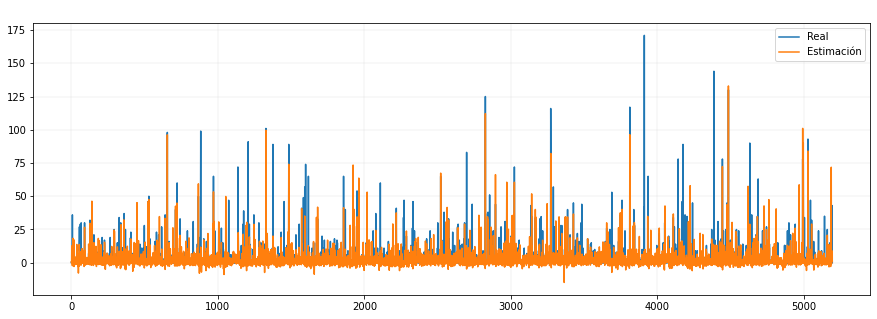




 Error Absoluto: 
            Mínimo: 0.00012 
            Promedio: 3.31033 ± 7.30590
            Máximo: 162.75516 


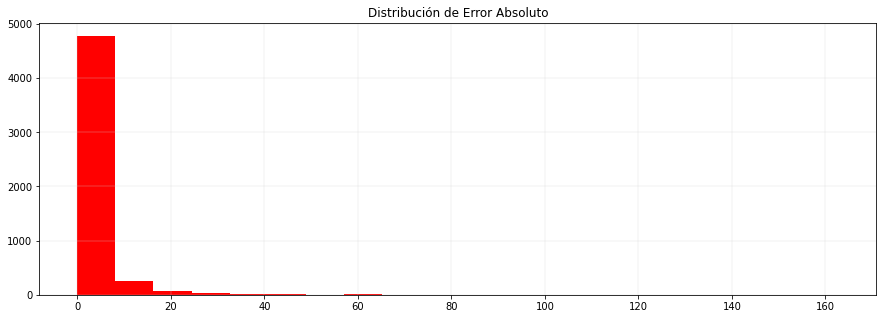


 Error Relativo: 
            Mínimo: 0.01% 
            Promedio: 15649658.53 ± 32337915.02
            Máximo: 718239135.74% 


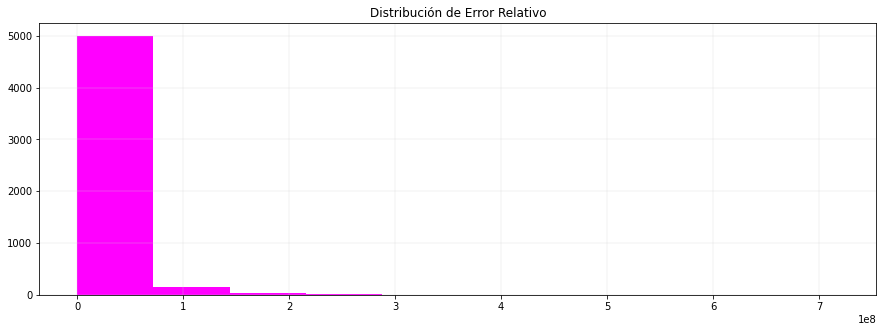

In [14]:
 #@title Probar red entrenada con datos de prueba
 # evalua al modelo entrenado

 mostrar_detalle_prueba = False #@param {type:"boolean"}

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
probarModelo(x_test, y_test, mostrar_detalle_prueba)